# Exploring Facebook Prophet (Book Club)

**Author:** [Dr. Eva Martínez](https://evadatinez.github.io/)

This notebook contains the code I presented for the BTSA book club session on the 11th August 2020.

It is a very introductory notebook to create predictions of time series data provided and measure their performance using [Facebook Prophet](https://facebook.github.io/prophet/).

## Setup and data exploration

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='muted')
sns_c = sns.color_palette(palette='muted')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Set global plot parameters 
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

The data provided contains a simmulation of `sales` data between `2018-01-01` and `2021-06-30`. In addition there is a feature `media` which could be used as an external predictor. Below I read the dataset and make simple transformations on the `date` column.

In [2]:
# read data
data = pd.read_csv('../data/sample_data_1.csv')

data_df = data_df.assign(
    date = lambda x: pd.to_datetime(x['date']), 
    year = lambda x: x['date'].dt.year,
    month = lambda x: x['date'].dt.month,
    day = lambda x: x['date'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear
)
data_df.head()

,date,media,sales,year,month,day,dayofyear
0,2018-01-03,0.0,6.258472,2018,1,3,3
1,2018-01-04,0.0,6.170889,2018,1,4,4
2,2018-01-05,0.0,5.754669,2018,1,5,5
3,2018-01-06,0.0,5.968413,2018,1,6,6
4,2018-01-07,0.0,5.285262,2018,1,7,7


Below I include a visualization of the `sales`and `media` data over `date`.  

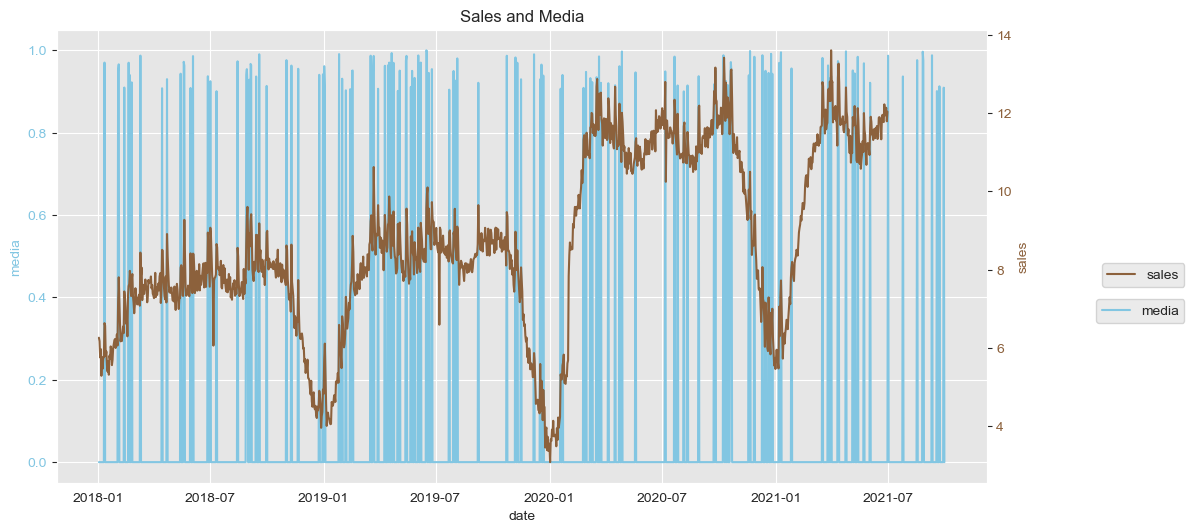

In [3]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='date', y='media', data=data_df, color=sns_c[9], label='media', ax=ax1)
sns.lineplot(x='date', y='sales', data=data_df, color=sns_c[5], label='sales', ax=ax2)
ax1.legend(bbox_to_anchor=(1.22, 0.42))
ax2.legend(bbox_to_anchor=(1.22, 0.5))
ax1.tick_params(axis='y', labelcolor=sns_c[9])
ax1.set_ylabel('media', fontdict={'color': sns_c[9]})
ax1.set(title='Sales and Media')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[5])
ax2.set_ylabel('sales', fontdict={'color': sns_c[5]});

Some conclusions I derived from this visualization:  
- `media` looks like is going to be a good candidate to external predictor of `sales`.  
- It looks like the feature `sales` shows clear yearly + quarterly seasonalities.   
- The time series `sales` seems to have a incresing multiplicative trend, since it does not only grows over time but also has increasing variation over time.   
- Doesn't look like there are missing `sales`data other than at the end of the time period (which is expected, since the exercise is to forecast).   
- There is a strange minimum appearing around the middle of the year, I will take a look at whether it coincides with a special date. 


First I confirm my assumption about missing values other than at the end of the period.

In [4]:
data_df.tail()

,date,media,sales,year,month,day,dayofyear
1362,2021-09-26,0.000000,NaN,2021,9,26,269
1363,2021-09-27,0.000000,NaN,2021,9,27,270
1364,2021-09-28,0.000000,NaN,2021,9,28,271
1365,2021-09-29,0.909033,NaN,2021,9,29,272
1366,2021-09-30,0.000000,NaN,2021,9,30,273


In [5]:
data_df[data_df.sales.notna()].date.max()

Timestamp('2021-06-30 00:00:00')

In [6]:
data_df[data_df.sales.isna()].date.min()

Timestamp('2021-07-01 00:00:00')

In [7]:
data_df.shape[0]

1367

In [8]:
data_df[data_df.sales.notna()].shape[0]

1275

In [9]:
data_df[data_df.sales.isna()].shape[0]

92

Next I inspect the misterious minimums around mid-year. Let us find out whether it is a consistent date (it may be a special holiday).

In [11]:
min_july_df = data_df.loc[data_df.month == 7 ][["year", "sales"]].groupby("year").min()
data_join_07min_df = data_df.join(min_july_df, on="year", rsuffix="07_min")
data_join_07min_df[data_join_07min_df.sales == data_join_07min_df.sales07_min]


,date,media,sales,year,month,day,dayofyear,sales07_min
185,2018-07-07,0.0,6.057521,2018,7,7,188,6.057521
550,2019-07-07,0.0,6.591582,2019,7,7,188,6.591582
916,2020-07-07,0.0,10.245428,2020,7,7,189,10.245428


indeed it coincides to 07.07, so I will create a dummy to encode it

In [12]:
def is_07_july(ds):
    date = pd.to_datetime(ds)
    return (date.month == 7 and date.day == 7)

Let us incorporate this new dummy in the data and subset the training dataset I will use for forecasting.

In [13]:
data_df["ds"] = data_df.date
data_df["y"] = data_df.sales
data_df["is_07_july"] = data_df["ds"].apply(is_07_july)

train_df = data_df[data_df.sales.notna()][["ds", "y", "media", "is_07_july"]]

## Forecasting

My idea now is to answer the question:   
> Is the feature media useful for prediction?

Therefore, I define 2 models:   
1. `m` is a simple model which will have multiplicative seasonality and prophet will capture the seasonality as well.   
2. `m_w_media_0707` is the same model as `m` with 2 external additive regressors: `media` and the dummy `is_07_july`.

I create a 30 days forecast for each of them.

In [14]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train_df[["ds", "y"]])
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast["errors"] = forecast.yhat - train_df.y

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
m_w_media_0707 = Prophet(seasonality_mode='multiplicative')
m_w_media_0707.add_regressor("media", mode="additive")
m_w_media_0707.add_regressor("is_07_july", mode="additive")
m_w_media_0707.fit(train_df)
future = m_w_media_0707.make_future_dataframe(periods=30)
future["media"] = data_df.loc[data_df.date <= future.ds.max()]["media"]
future["is_07_july"] = future["ds"].apply(is_07_july)
forecast_w_media_0707 = m_w_media_0707.predict(future)
forecast_w_media_0707["errors"] = forecast_w_media_0707.yhat - train_df.y

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet very easily plots the calculated forecast, including the training data & confidence intervals.

Below, one can cleary see the difference between the two models.

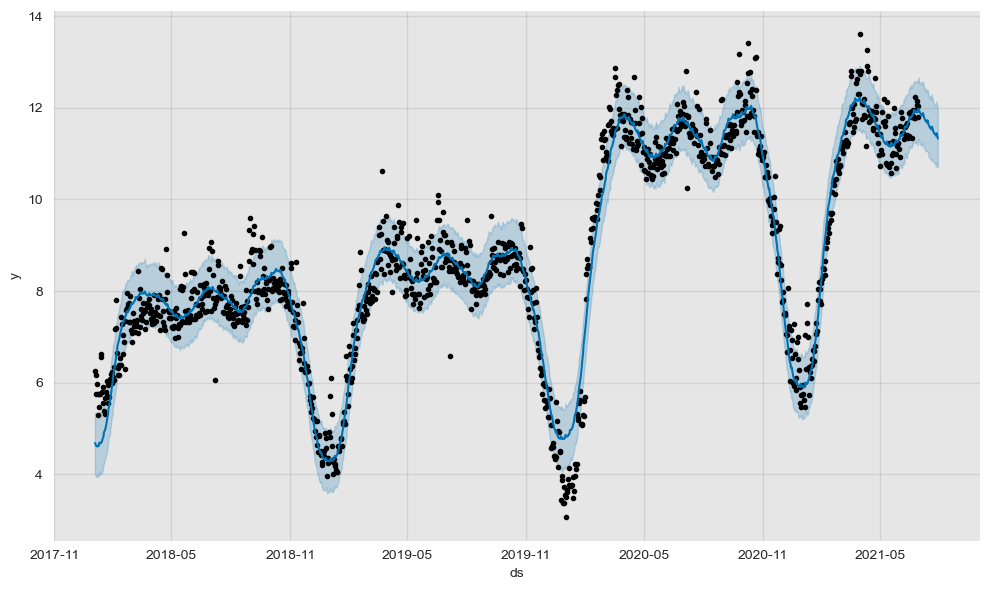

In [16]:
fig1 = m.plot(forecast)

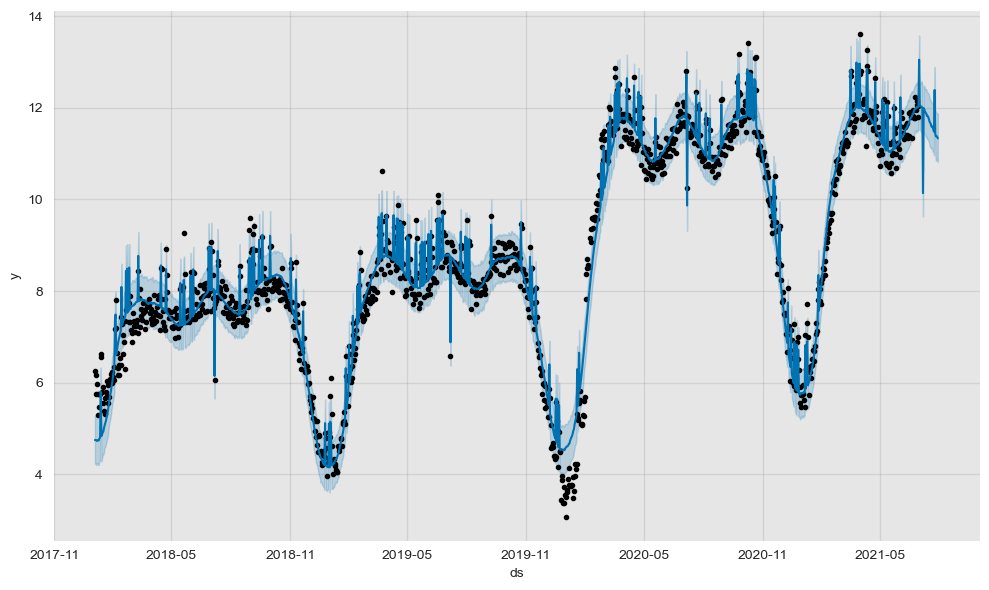

In [23]:
fig1_media_0707 = m_w_media_0707.plot(forecast_w_media_0707)

Moreover, with the `plot_components` function one can very easily inspect the trend and seasonality Prohet captures form the models.

I have commented out the visualization for the second model since they are the same for both models.

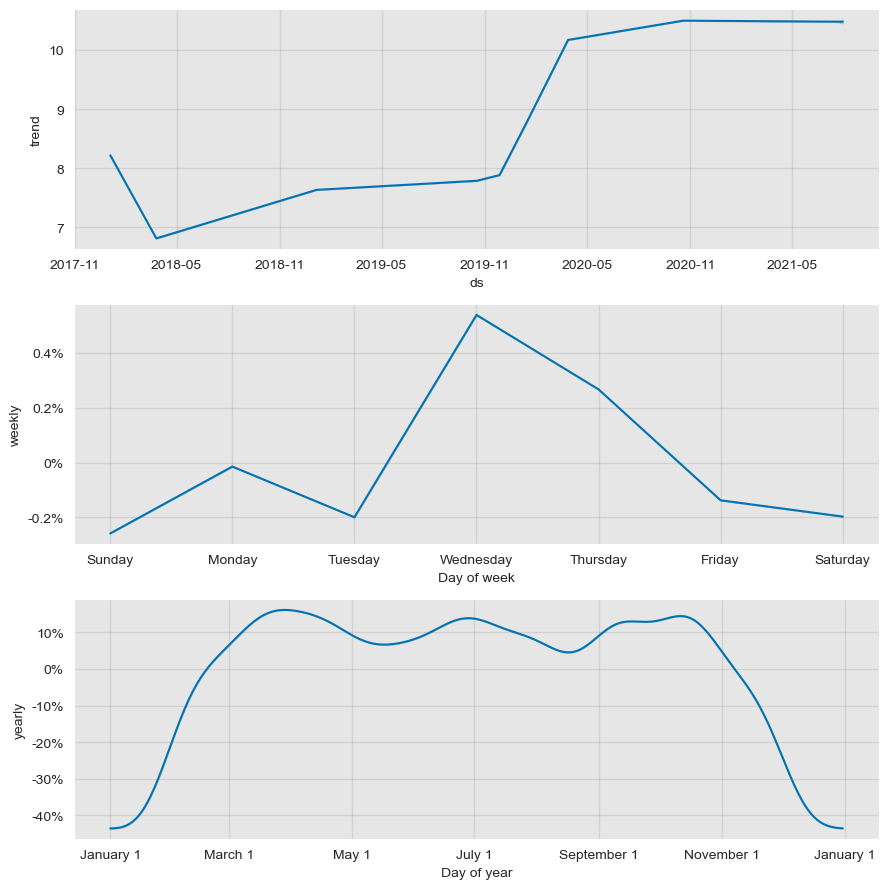

In [18]:
fig2 = m.plot_components(forecast)

In [19]:
# fig2_media_0707 = m_w_media_0707.plot_components(forecast_w_media_0707)

Next I plot the `sales`time series with its forecast in the left `y` axis. In the right `y` axis one can see the errors of the forecast. 

For the first model (where nly seasonality and trend are considered) one can see the big errors in July which dissapear in the second model, thanks to the dummy variable. Also the overal range of errors seems to decrease a bit (from (-2.0, 2.0) to (-1.5, 1.5)). However, in both models there is something annoying at the end 2019. I have tried to create a dummy around those dates but it did not work.

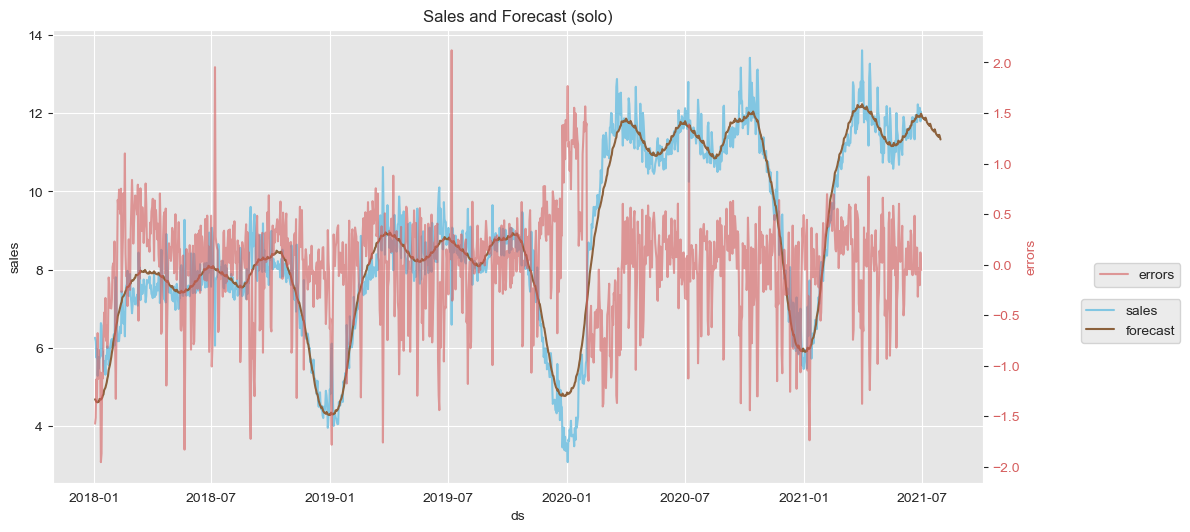

In [20]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='ds', y='errors', data=forecast, color=sns_c[3], label='errors', ax=ax2, alpha=0.6)
sns.lineplot(x='ds', y='y', data=data_df[data_df.sales.notna()], color=sns_c[9], label='sales', ax=ax1)
sns.lineplot(x='ds', y='yhat', data=forecast, color=sns_c[5], label='forecast', ax=ax1)
ax1.legend(bbox_to_anchor=(1.22, 0.42))
ax2.legend(bbox_to_anchor=(1.22, 0.5))
ax1.tick_params(axis='y')
ax1.set_ylabel('sales')
ax1.set(title='Sales and Forecast (solo)')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[3])
ax2.set_ylabel('errors', fontdict={'color': sns_c[3]});

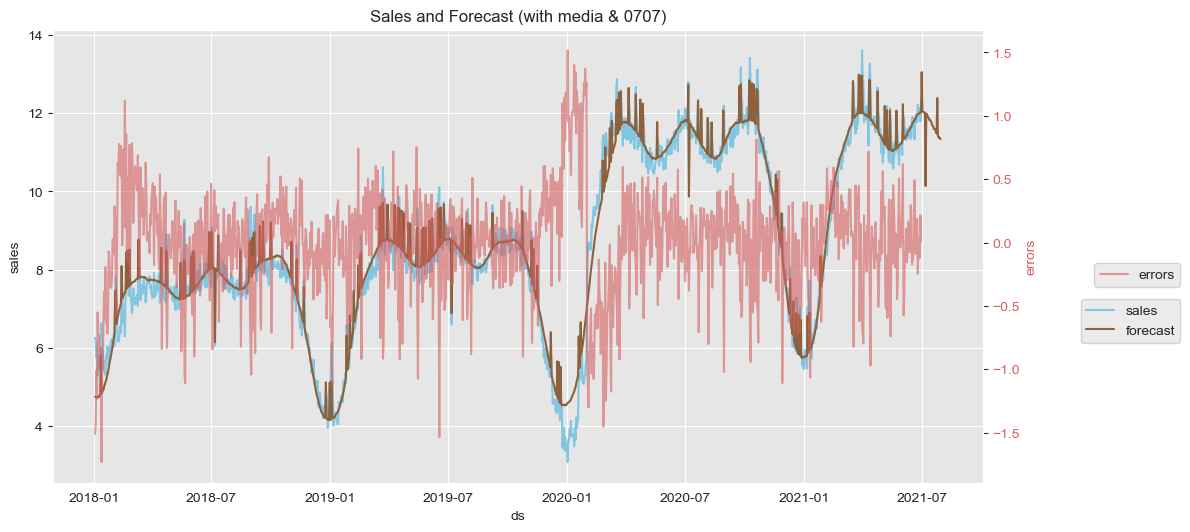

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='ds', y='errors', data=forecast_w_media_0707, color=sns_c[3], label='errors', ax=ax2, alpha=0.6)
sns.lineplot(x='ds', y='y', data=data_df[data_df.sales.notna()], color=sns_c[9], label='sales', ax=ax1)
sns.lineplot(x='ds', y='yhat', data=forecast_w_media_0707, color=sns_c[5], label='forecast', ax=ax1)
ax1.legend(bbox_to_anchor=(1.22, 0.42))
ax2.legend(bbox_to_anchor=(1.22, 0.5))
ax1.tick_params(axis='y')
ax1.set_ylabel('sales')
ax1.set(title='Sales and Forecast (with media & 0707)')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[3])
ax2.set_ylabel('errors', fontdict={'color': sns_c[3]});

## Evaluation of model performance

I will make use of Prophet's crossvalidation function to evaluate the performance of the models created above.

For this, one needs to set some constants:   
- `cv_initial`:  an initial set of points to be included in the first iteration as training data. ideally they should include a full seasonality and trend loop in order to account for it in the following predictions.    
- `cv_period`: how many data points will be included to the training set after each iteration.    
- `cv_horizon`: what will be the forecasting window at each iteration. (I personally like the analogy with the horizon which moves with you at every step you make & is never to be reached :) )   


In [22]:
from fbprophet.diagnostics import cross_validation
cv_initial = '1185 days'
cv_period = '7 days'
cv_horizon = '30 days'
df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon = cv_horizon)
# df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2021-04-05 00:00:00 and 2021-05-31 00:00:00


In [24]:
df_cv_w_media_0707 = cross_validation(m_w_media_0707, initial=cv_initial,       
                                        period=cv_period, horizon = cv_horizon)
# df_cv_w_media_0707.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2021-04-05 00:00:00 and 2021-05-31 00:00:00


Later, with the `performance_metrics` function, one gets a dataframe summarizing the metrics averaging the forecast errors at every horizon day.

In [25]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,0.184054,0.429015,0.372012,0.032679,0.030733,0.851852
1,4 days,0.161923,0.402396,0.338746,0.029616,0.030733,0.925926
2,5 days,0.219794,0.468822,0.363396,0.031197,0.028344,0.814815
3,6 days,0.243696,0.493656,0.374984,0.031986,0.022488,0.777778
4,7 days,0.287547,0.536234,0.399342,0.033638,0.023716,0.740741


In [26]:
df_p_w_media_0707 = performance_metrics(df_cv_w_media_0707)
df_p_w_media_0707.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,0.138125,0.371652,0.300312,0.026310,0.021001,0.814815
1,4 days,0.118737,0.344582,0.284383,0.024855,0.018320,0.814815
2,5 days,0.106944,0.327023,0.243355,0.021236,0.013283,0.814815
3,6 days,0.112950,0.336080,0.244234,0.021324,0.010519,0.814815
4,7 days,0.104026,0.322530,0.245283,0.021298,0.016246,0.851852


In [27]:
# extracting the horizon days
df_p = df_p.assign(
    horizon_days = lambda x: x['horizon'].dt.days
)
df_p_w_media_0707 = df_p_w_media_0707.assign(
    horizon_days = lambda x: x['horizon'].dt.days
)

Finally, by selecting the desired metric in the `metric`to_plot`variable, I plot a comparison of the desired performance metric for both metric.

As an example, I select the `mae`= *Mean Average Error*. It shows that the second model performs much better than the simple one.   

In [28]:
metric_to_plot = 'mae'

In [29]:
df_perf_plot_wide = df_p[['horizon_days', metric_to_plot]].join(df_p_w_media_0707[['horizon_days', metric_to_plot]].set_index('horizon_days'), on='horizon_days',  lsuffix='_simple', rsuffix='_w_media_0707')
df_perf_plot_long = pd.melt(df_perf_plot_wide, id_vars=['horizon_days'], value_vars=[metric_to_plot + '_simple', metric_to_plot + '_w_media_0707'])

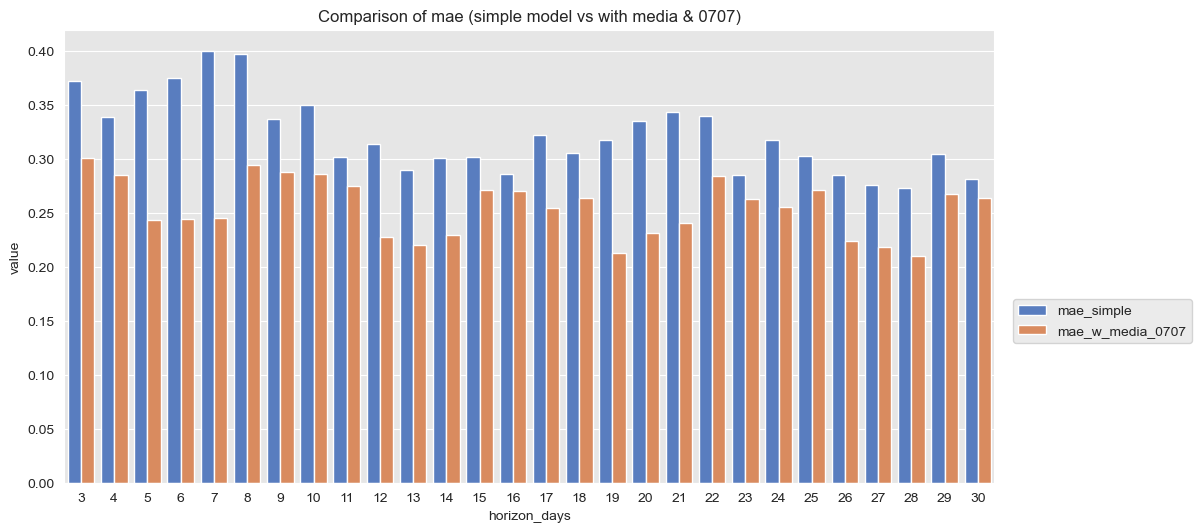

In [30]:
fig, ax = plt.subplots()
sns.barplot(x='horizon_days', y='value', hue='variable', data=df_perf_plot_long, ax=ax)
ax.legend(bbox_to_anchor=(1.22, 0.42))
ax.set(title=f'Comparison of {metric_to_plot} (simple model vs with media & 0707)');

If one wants more detail, the `plot_cross_validation_metric` function easily plot sthe average metrics with the real values for each horizon day.

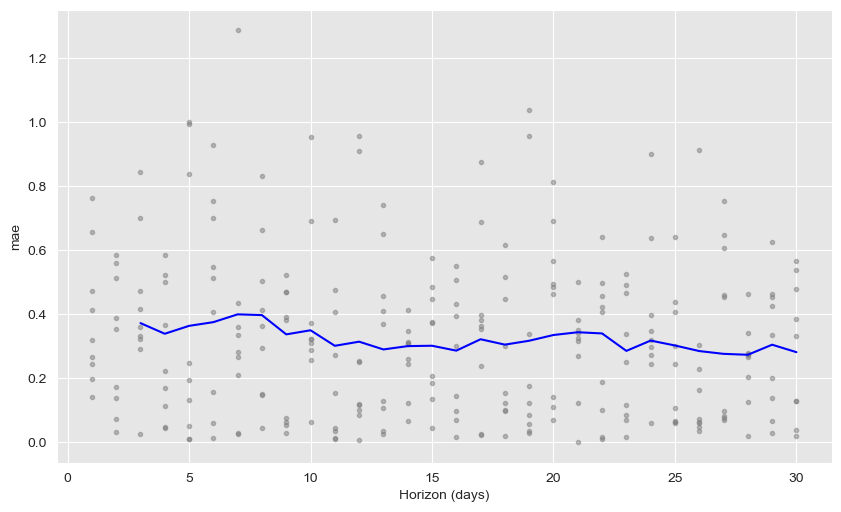

In [31]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric=metric_to_plot)

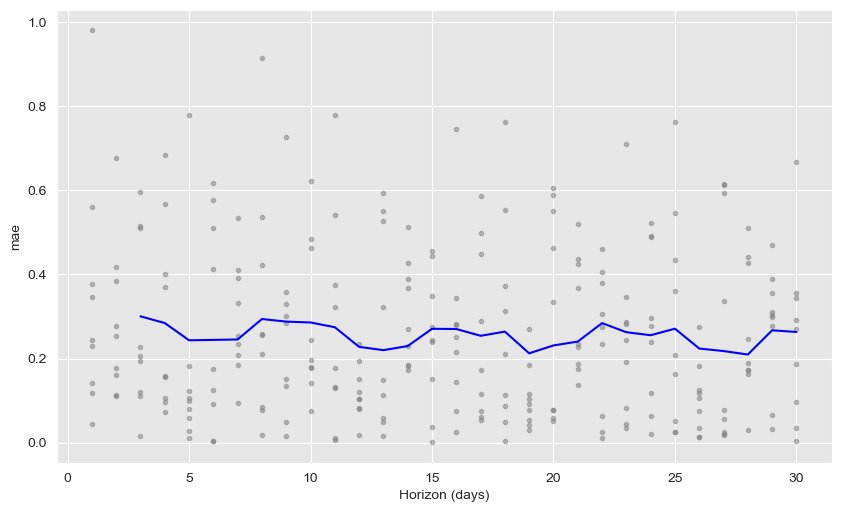

In [32]:
fig = plot_cross_validation_metric(df_cv_w_media_0707, metric=metric_to_plot)